# Set Training data
Having organized the time series of earth observation images in a consistent dataset, this can now be manipulated to incorporate new temporal variables or incorporate other data. In this notebook, three different operations are demosntrated:

- Calculation of temporal trends of a band (e.g. NDVI)
- Training Data classes using a shapefile
- Serialization and reading of xarray Dataset and netCDF files

## Construction of xarray Dataset
Using the eo_stack classes demonstrated in [previous notebook], a Dataset of 8 Sentinel-2 images for the Saldana region in constructed.

In [1]:
from eo_stack import *
s2 = S2TempStack('/home/azalazar/data/Saldana/pre/', '/home/azalazar/data/Saldana/pre/stack/')
#s2_xar = s2.getXarray()
#s2_xds = s2.getXDataset()

S2 object initialized from /home/azalazar/data/Saldana/pre/


In [5]:
s2_xar = s2.getXarray()

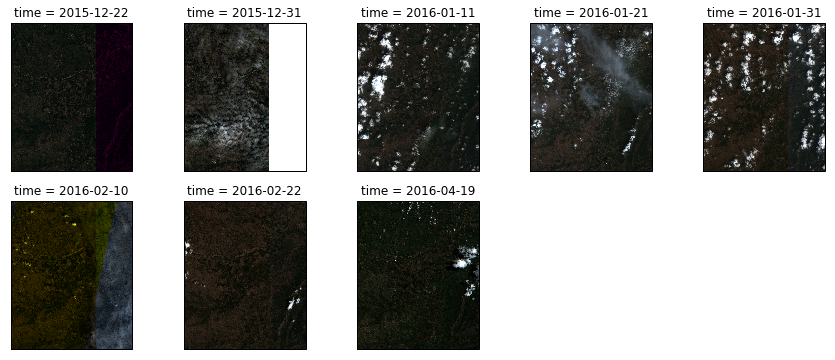

In [7]:
from eotemparray import *
s2_xar.eotemp.plot_RGB()

## Calculation of temporal trends
Calculate NDVI change from last image, i.e. slope, first derivative

In [94]:
s2_xds

<xarray.Dataset>
Dimensions:   (time: 8, x: 2979, y: 3631)
Coordinates:
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
    band      int64 1
  * y         (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time      (time) datetime64[ns] 2015-12-22 2015-12-31 2016-01-11 ...
    mask      (time, y, x) bool True True True True True True True True True ...
Data variables:
    blue      (time, y, x) float64 298.0 255.0 270.0 339.0 433.0 514.0 459.0 ...
    swir1     (time, y, x) float64 1.78e+03 1.78e+03 1.944e+03 1.944e+03 ...
    swir2     (time, y, x) float64 781.0 781.0 877.0 877.0 1.181e+03 ...
    qa_class  (time, y, x) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 ...
    qa_cloud  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    green     (time, y, x) float64 476.0 380.0 449.0 573.0 672.0 755.0 727.0 ...
    nir       (time, y, x) float64 3.626e+03 2.894e+03 3.395e+03 4.204e+03 ...
    NDVI      (time, y, x) 

In [2]:
# Constrcut xarray Datataset
s2_xds = s2.getXDataset()

In [45]:
# Make sure is sorted by time (last time is last observation)
s2_xds = s2_xds.sortby('time')

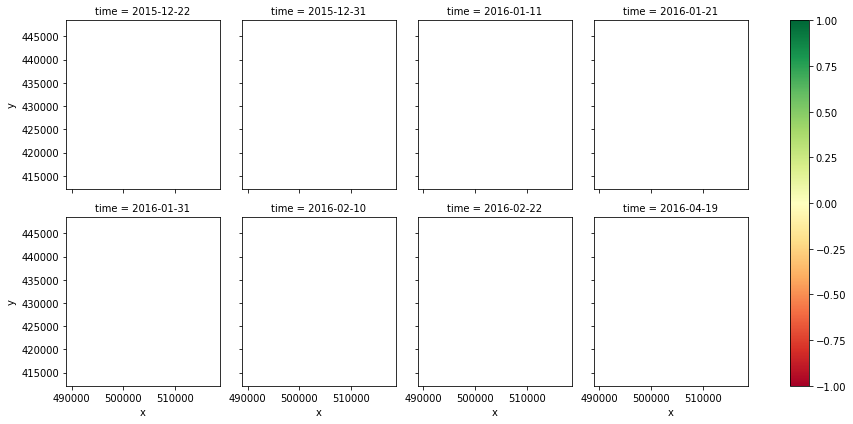

In [86]:
# Plot all NDVI using mask (facetgrid not working, all plots blank)
s2_xds.NDVI.where(s2_xds.mask).plot(col='time', col_wrap=4, vmin=-1., vmax=1., cmap='RdYlGn', sharex=True, sharey=True)

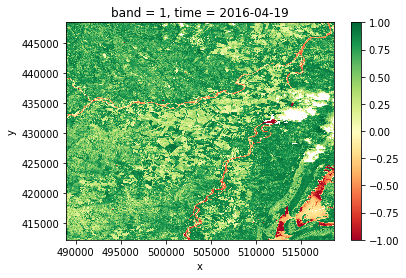

In [87]:
# Individual plots do work
s2_xds.NDVI.isel(time=-1).where(s2_xds.mask.isel(time=-1)).plot(vmin=-1., vmax=1., cmap='RdYlGn')

In [88]:
# Extract ndvi values and dates, from last 2 dates
vals = s2_xds.isel(time=slice(-2,None)).NDVI.values
time = s2_xds.isel(time=slice(-2,None)).time.values.astype(long)
time

array([1456099200000000000, 1461024000000000000])

In [79]:
# Reshape to an array with as many rows as dates and as many columns as there are pixels
vals2 = vals.reshape(len(time), -1)
# Do a first-degree polyfit
regressions = np.polyfit(time, vals2, 1)
# Get the slope coefficient and reshape to y,x shape
trends = regressions[0,:].reshape(vals.shape[1], vals.shape[2])

In [80]:
# Join with original dataset reduced to the last time observation
last_wt = s2_xds.isel(time=-1).assign(NDVI_trend=(['y','x'],trends))

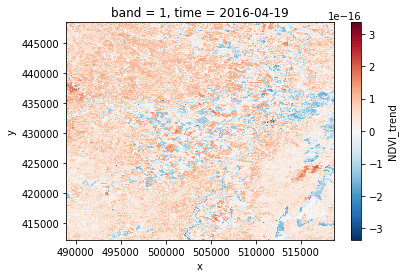

In [81]:
# Plot the trend from the joined xarray dataset
last_wt.NDVI_trend.plot()

## Training classes from shapefile
the general approach is reading and rasterizing shapefiles using rasterio (need to reproject to eo images crs). The resulting object can the be read using xarray rasterio method, which can be used to mask xarray objects.

In [2]:
import rasterio, dask
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from affine import Affine
from rasterio import features

In [3]:
reference_file = "/home/azalazar/data/Saldana/pre/stack/NDVI_S2_20160222_.tif"
rasterized_file = '/home/azalazar/data/training_data/test_raster.tif'

In [4]:
out_dir = '/home/azalazar/data/training_data/'

rst = rasterio.open(reference_file)
meta = rst.meta.copy()
meta.update(compress='lzw', dtype=rasterio.float64)

dates = []

lotes = gpd.read_file('/home/azalazar/data/training_data/saldana.shp').to_crs({'init': 'epsg:32618'})

for column in lotes:
    
    if lotes[column].name[0] == 'X':
        
        date = lotes[column].name[1:]
        out_file = out_dir+date+'.tif'
        
        dates.append(date)
        
        #with rasterio.open(out_file, 'w', **meta) as out:
        #    out_arr = out.read(1)
        #    shapes = ((geom,value) for geom, value in zip(lotes.geometry, lotes[column].astype('float64')))
        #    burned = rasterio.features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
        #    out.write_band(1, burned.astype(rasterio.float64))

In [5]:
dates = ['20151222', '20151231', '20160111', '20160121']
dates2 = ['2015-12-22', '2015-12-31', '2016-01-11', '2016-01-21']

In [6]:
def getXarray(raster_dir, dates):
    """Returns an xarray object from all dates in a given band"""
    time = xr.Variable('time', pd.DatetimeIndex([pd.Timestamp(f) for f in dates]))
    arlist = [xr.open_rasterio(f) for f in list(map(lambda x: raster_dir+x+'.tif', dates))]
    da = xr.concat(arlist, dim=time)
    return da

rice_plots_ph = getXarray(out_dir, dates).isel(band=0).drop('band')

In [7]:
app = []
for date in dates2:
    app.append(s2_xds.sel(time=date))
sat_data = xr.concat(app, 'time').transpose('time','x','y')

In [8]:
class_data = rice_plots_ph.transpose('time','x','y')

In [9]:
sat_data['phc'] = (('time', 'x', 'y'), class_data)

In [41]:
pddf = sat_data.to_dataframe()

In [60]:
valid = pddf.loc[pddf['phc'] > 0]
valid2 = valid.loc[valid['mask'] == True]

In [61]:
valid2

blue   swir1   swir2  qa_class  qa_cloud  \
time       x        y                                                      
2015-12-22 499455.0 425215.0   312.0  1127.0   529.0       4.0       0.0   
                    425205.0   297.0  1127.0   529.0       4.0       0.0   
                    425195.0   326.0  1177.0   578.0       4.0       0.0   
           499465.0 425245.0   342.0  1199.0   605.0       4.0       0.0   
                    425235.0   321.0  1256.0   622.0       4.0       0.0   
                    425225.0   347.0  1256.0   622.0       4.0       0.0   
                    425215.0   340.0  1243.0   610.0       4.0       0.0   
                    425205.0   313.0  1243.0   610.0       4.0       0.0   
                    425195.0   328.0  1210.0   587.0       4.0       0.0   
                    425185.0   315.0  1210.0   587.0       4.0       0.0   
           499475.0 425265.0   326.0  1222.0   616.0       4.0       0.0   
                    425255.0   334.0  1199.0   605.0       4.0       0.0   
                    425245.0   332.0  1199.0   605.0       4.0       0.0   
                    425235.0   331.0  1256.0   622.0       4.0       0.0   
                    425225.0   332.0  1256.0   622.0       4.0       0.0   
                    425215.0   305.0  1243.0   610.0       4.0       0.0   
                    425205.0   289.0  1243.0   610.0       4.0       0.0   
                    425195.0   307.0  1210.0   587.0       4.0       0.0   
                    425185.0   297.0  1210.0   587.0       4.0       0.0   
           499485.0 425285.0   311.0  1173.0   523.0       4.0       0.0   
                    425275.0   305.0  1141.0   528.0       4.0       0.0   
                    425265.0   310.0  1141.0   528.0       4.0       0.0   
                    425255.0   316.0  1251.0   594.0       4.0       0.0   
                    425245.0   321.0  1251.0   594.0       4.0       0.0   
                    425235.0   331.0  1424.0   661.0       4.0       0.0   
                    425225.0   337.0  1424.0   661.0       4.0       0.0   
                    425215.0   337.0  1359.0   661.0       4.0       0.0   
                    425205.0   299.0  1359.0   661.0       4.0       0.0   
                    425195.0   315.0  1275.0   610.0       4.0       0.0   
                    425185.0   307.0  1275.0   610.0       4.0       0.0   
...                              ...     ...     ...       ...       ...   
2016-01-21 503815.0 433835.0  1028.0  2076.0  1222.0      10.0       1.0   
                    433825.0  1054.0  2076.0  1222.0      10.0       1.0   
                    433775.0  1003.0  1996.0  1158.0      10.0       2.0   
                    433765.0  1054.0  1996.0  1158.0      10.0       2.0   
                    433755.0  1078.0  1963.0  1153.0      10.0       6.0   
                    433745.0  1019.0  1963.0  1153.0      10.0       6.0   
                    433735.0  1053.0  1962.0  1144.0      10.0       5.0   
                    433725.0  1048.0  1962.0  1144.0      10.0       5.0   
           503825.0 433775.0  1006.0  1981.0  1163.0      10.0       2.0   
                    433765.0  1017.0  1981.0  1163.0      10.0       2.0   
                    433755.0   998.0  1961.0  1158.0      10.0       3.0   
                    433745.0  1011.0  1961.0  1158.0      10.0       3.0   
                    433735.0  1059.0  1966.0  1153.0      10.0       2.0   
                    433725.0  1029.0  1966.0  1153.0      10.0       2.0   
           503835.0 433775.0   969.0  1981.0  1163.0      10.0       2.0   
                    433765.0  1017.0  1981.0  1163.0      10.0       2.0   
                    433755.0  1036.0  1961.0  1158.0      10.0       3.0   
                    433745.0  1011.0  1961.0  1158.0      10.0       3.0   
                    433735.0  1041.0  1966.0  1153.0      10.0       2.0   
                    433725.0  1008.0  1966.0  1153.0      10.0       2.0   
    

In [62]:
backxa = xr.Dataset.from_dataframe(valid2)
backxa

<xarray.Dataset>
Dimensions:   (time: 4, x: 2979, y: 3631)
Coordinates:
  * time      (time) datetime64[ns] 2015-12-22 2015-12-31 2016-01-11 2016-01-21
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y         (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
Data variables:
    blue      (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir1     (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir2     (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    qa_class  (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    qa_cloud  (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    green     (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir       (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    NDVI      (time, x, y) float32 nan nan nan nan nan nan nan nan nan nan ...
    LSWI      (time, x, y) float32 nan n

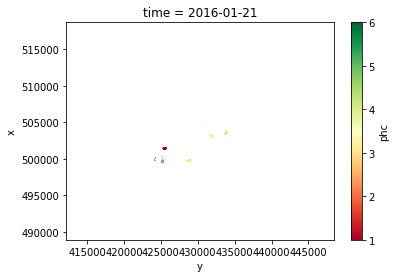

In [63]:
backxa['phc'].sel(time='2016-01-21').plot(vmin=1., vmax=6., cmap='RdYlGn')

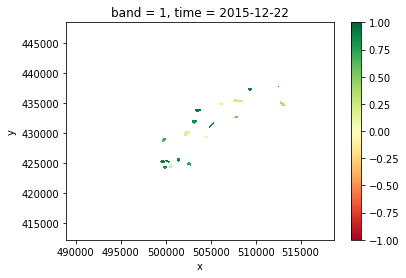

In [101]:
s2_xds['NDVI'].sel(time='20151222').where(rice_plots_ph.sel(time='20151222')!=0).plot(vmin=-1., vmax=1., cmap='RdYlGn')

## Serialization and reading
Using to_netcdf. Please note that the parameters are not optimized. Extensive documentation on this topic is available at http://xarray.pydata.org/en/stable/io.html and https://www.unidata.ucar.edu/blogs/developer/en/entry/netcdf_compression

In [64]:
## Store data in disk

sat_data.to_netcdf('/home/azalazar/data/training_data/s2phc.nc')

In [65]:
## Read from disk

sat_data_again = xr.open_mfdataset('/home/azalazar/data/training_data/s2phc.nc')
sat_data_again

<xarray.Dataset>
Dimensions:   (time: 4, x: 2979, y: 3631)
Coordinates:
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y         (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time      (time) datetime64[ns] 2015-12-22 2015-12-31 2016-01-11 2016-01-21
    mask      (time, x, y) bool dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
Data variables:
    blue      (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    swir1     (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    swir2     (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    qa_class  (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    qa_cloud  (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    green     (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
   

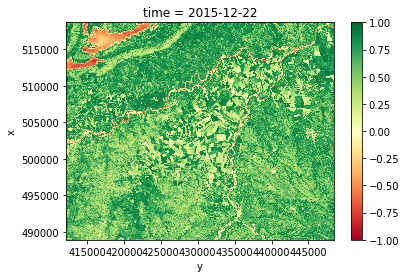

In [71]:
sat_data_again['NDVI'].sel(time='2015-12-22').where(sat_data_again.mask.sel(time='2015-12-22')).plot(vmin=-1., vmax=1., cmap='RdYlGn')